# Behavioral Cloning

This project is part of [Udacity](https://www.udacity.com)'s [Self-driving Car Engineer Nanodegree](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013) program. The goal of this project is to clone driving behavior using convolutional neural networks (CNNs).

## The Project
This project has the following requirements:

* Use a simulator to collect data of good driving behavior 
* Design, train and validate a model that predicts a steering angle from image data
* Use the model to drive the vehicle autonomously around the first track in the simulator. The vehicle should remain on the road for an entire loop around the track.
* Summarize the results with a written report

The written report is in the file [writeup.md](writeup.md).

The purpose of this notebook is to explore the data and the code, and provide an option for training the model. The actual source code for the project is contained in Python files in the `vehicle_control` module, and described in [writeup.md](writeup.md).

This animated GIF shows an extract of the car driving autonomously around the track. Videos of the car completing a full lap are below.

![](output_videos/behavioral_cloning_lap.gif)


In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2

import ntpath
import random

from imgaug import augmenters as ima

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I created the `vehicle_control` module for this project.

In [49]:
from vehicle_control.model.data_manager import DataManager
from vehicle_control.model.model_builder import VehicleControlModelBuilder
from vehicle_control.model.model_trainer import ModelTrainer
from vehicle_control.model.image_augmentor import ImageAugmentor
from vehicle_control.model.batch_image_generator import BatchImageGenerator

## Explore the Test Data from the Self-driving Car Simulator

This shows the directory structure and contents for this project.

In [50]:
!ls

CarND.yml                data                     vehicle_control
Models                   images                   video.py
README.md                output_images            writeup.md
Simulator                output_videos
behavioral_cloning.ipynb tests


The `Data` directory contains the data generated by the simulator during training. I trained it in multiple runs. E.g., the data from one run is stored in `Driving Dataset 01`, while the data from a second run is stored in `Driving Dataset 02`. This notebook uses the second set of data I captured.

In [51]:
!ls "data/"

new      new copy


It captures images as `JPG` files from each of the three cameras, and stores them in the `Data/IMG` directory. The file `driving_log.csv` contains a summary of the data. We will explore its contents a little further down. 

In [52]:
!ls "data/new/IMG" | wc -l

   73686


There are over 57,000 images in the test data set. These were genereated from performing 4 laps of the driving circuit, in each direction for a total of 8 laps. The reason I drove the car in both directions is to get a better dataset. Driving in one direction would result in most of the turns being left turns or right turns, depending on the direction of driving. Driving the same number of times around the track in both directions gives a more even distribution of data, which I verify below.

Let's look at the first few images from the left camera, the center camera, and the right camera.

In [53]:
!ls "data/new/IMG/" | grep 'left*' | head -3
!ls "data/new/IMG/" | grep 'center*' | head -3
!ls "data/new/IMG/" | grep 'right*' | head -3

left_2021_07_02_16_12_36_240.jpg
left_2021_07_02_16_12_36_308.jpg
left_2021_07_02_16_12_36_376.jpg
center_2021_07_02_16_12_36_240.jpg
center_2021_07_02_16_12_36_308.jpg
center_2021_07_02_16_12_36_376.jpg
right_2021_07_02_16_12_36_240.jpg
right_2021_07_02_16_12_36_308.jpg
right_2021_07_02_16_12_36_376.jpg


In [54]:
datadir = 'data/new'
datafile = 'driving_log.csv'

data_manager = DataManager(datadir, datafile)

In [55]:
data_manager.get_data().head()

center                              left  \
0  center_2021_07_02_16_12_36_240.jpg  left_2021_07_02_16_12_36_240.jpg   
1  center_2021_07_02_16_12_36_308.jpg  left_2021_07_02_16_12_36_308.jpg   
2  center_2021_07_02_16_12_36_376.jpg  left_2021_07_02_16_12_36_376.jpg   
3  center_2021_07_02_16_12_36_444.jpg  left_2021_07_02_16_12_36_444.jpg   
4  center_2021_07_02_16_12_36_512.jpg  left_2021_07_02_16_12_36_512.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_07_02_16_12_36_240.jpg       0.0       0.0      0.0  0.000003  
1  right_2021_07_02_16_12_36_308.jpg       0.0       0.0      0.0  0.000012  
2  right_2021_07_02_16_12_36_376.jpg       0.0       0.0      0.0  0.000017  
3  right_2021_07_02_16_12_36_444.jpg       0.0       0.0      0.0  0.000003  
4  right_2021_07_02_16_12_36_512.jpg       0.0       0.0      0.0  0.000017

In [56]:
data_manager.get_data().tail()

center                              left  \
24557  center_2021_07_07_12_06_48_368.jpg  left_2021_07_07_12_06_48_368.jpg   
24558  center_2021_07_07_12_06_48_437.jpg  left_2021_07_07_12_06_48_437.jpg   
24559  center_2021_07_07_12_06_48_506.jpg  left_2021_07_07_12_06_48_506.jpg   
24560  center_2021_07_07_12_06_48_573.jpg  left_2021_07_07_12_06_48_573.jpg   
24561  center_2021_07_07_12_06_48_677.jpg  left_2021_07_07_12_06_48_677.jpg   

                                   right  steering  throttle  reverse  \
24557  right_2021_07_07_12_06_48_368.jpg       0.0       0.0      0.0   
24558  right_2021_07_07_12_06_48_437.jpg       0.0       0.0      0.0   
24559  right_2021_07_07_12_06_48_506.jpg       0.0       0.0      0.0   
24560  right_2021_07_07_12_06_48_573.jpg       0.0       0.0      0.0   
24561  right_2021_07_07_12_06_48_677.jpg       0.0       0.0      0.0   

          speed  
24557  0.707848  
24558  0.413303  
24559  0.121017  
24560  0.273649  
24561  0.334128

Merge the data from all the datasets into a single dataframe:

### Steering angle data
We will be using the steering angle data to train the network to steer the car. 

Plot the steering angles on a distribution, to see which angles are most frequent.

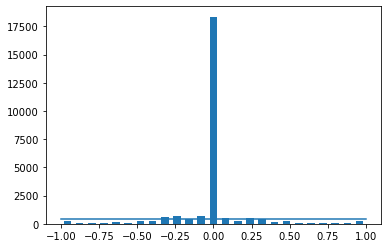

In [57]:
num_bins = 25
max_samples_per_bin = 400

hist, bins = np.histogram(data_manager.steering_data(), num_bins)

center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data_manager.steering_data()), 
          np.max(data_manager.steering_data())), 
         (max_samples_per_bin, max_samples_per_bin))

As might be expected, this shows that the angle of `0.0`, representing straight ahead, is the most common steering angle. However, for the purposes of training our neural network, this presents a problem because the center value dominate all other values, which would introduce bias in training our network.

The solution is to remove a set of the data from the center of the dataset, which results in a more normalized distribution of the data.

In [58]:
data_manager.normalize_steering_data()

total data 24562
removed: 19075
remaining: 5487


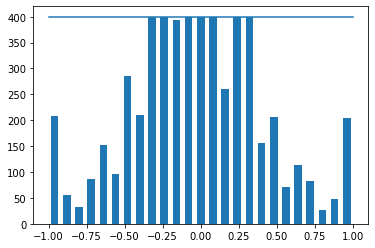

In [59]:
hist, _ = np.histogram(data_manager.steering_data(), (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data_manager.steering_data()), 
          np.max(data_manager.steering_data())), 
         (max_samples_per_bin, max_samples_per_bin))             

## Training and Validation Split

In [60]:
print(data_manager.get_data().iloc[1])

center      center_2021_07_02_16_12_37_822.jpg
left          left_2021_07_02_16_12_37_822.jpg
right        right_2021_07_02_16_12_37_822.jpg
steering                                 -0.35
throttle                                     0
reverse                                      0
speed                                 0.397026
Name: 23, dtype: object


In [61]:
X_train, X_valid, y_train, y_valid = data_manager.training_and_test_data()

print('Training samples: {}'.format(len(X_train)))
print('Validation samples: {}'.format(len(X_valid)))

Training samples: 4389
Validation samples: 1098


Text(0.5, 1.0, 'Validation set')

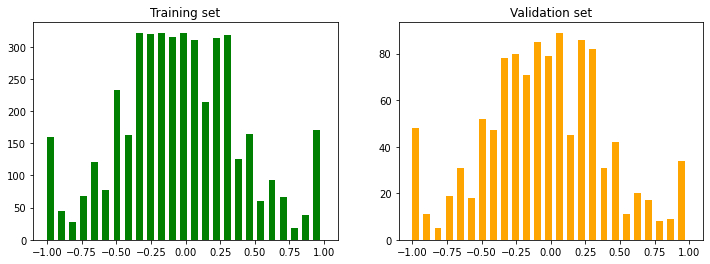

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='green')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='orange')
axes[1].set_title('Validation set')

## Generate additional data using augmentation techniques

Applying augmentation techniques is a useful way to create more data from our existing data. This section of the notebook shows how I use zooming, panning, brightness, and flipping to create additional data for training the network. I then randomly apply multiple augmentations to the orginal data, so that, for example, one input image could result in an output image that is a variation that is flipped, rotated, and made brighter.

In [63]:
image_paths, steering_data = data_manager.image_and_steering_data()

### Utility Functions

In [64]:
def plot_two_images(image1, image2, title1="Image 1", title2="Image 2"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()

    axes[0].imshow(image1)
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].set_title(title2)

### Zooming

In [65]:
image_augmentor = ImageAugmentor()

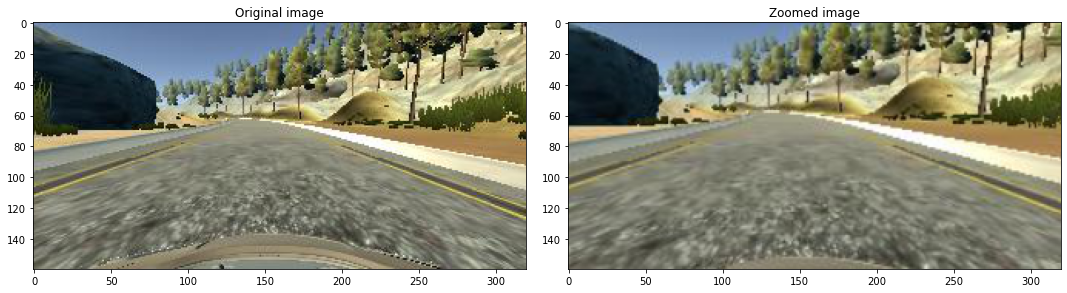

In [66]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)

zoomed_image = image_augmentor.zoom(original_image)

plot_two_images(original_image, zoomed_image, "Original image", "Zoomed image")

### Image panning

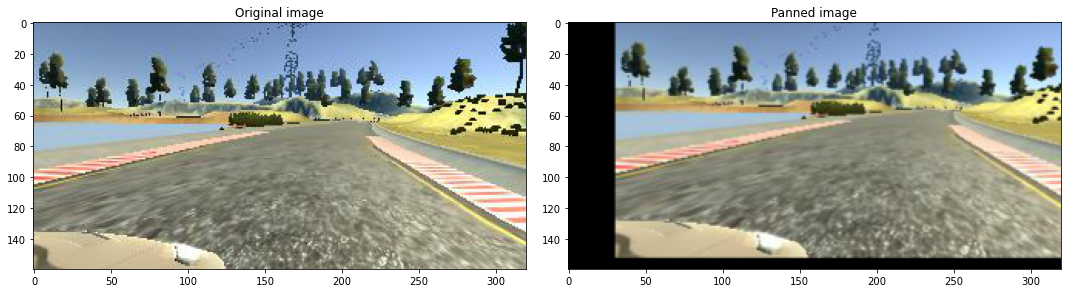

In [67]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)

panned_image = image_augmentor.pan(original_image)

plot_two_images(original_image, panned_image, "Original image", "Panned image")

### Image brightness

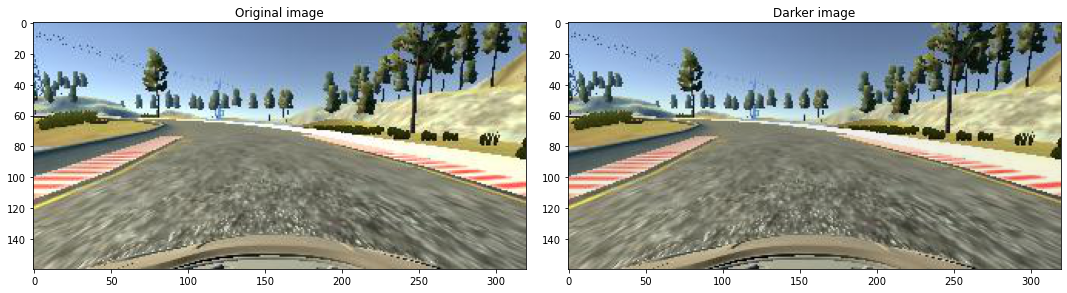

In [68]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)

darker_image = image_augmentor.randomly_alter_brightness(original_image)

plot_two_images(original_image, darker_image, "Original image", "Darker image")

### Flipping

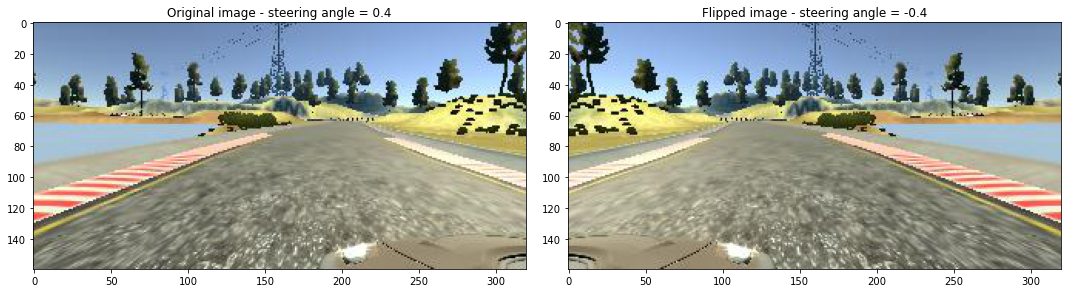

In [69]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steering_data[random_index]


original_image = mpimg.imread(image)

flipped_image, flipped_steering_angle = image_augmentor.flip(original_image, steering_angle)

plot_two_images(
    original_image, 
    flipped_image, 
    "Original image - steering angle = {}".format(steering_angle), 
    "Flipped image - steering angle = {}".format(flipped_steering_angle)
)

### Randomly apply the augmentations
Note it may look like more than one transformation is being applied to a given original image, e.g., the augmented image may be flipped and darkened.

In [70]:
def plot_ten_random_augmented_images():
    columns = 2
    rows = 10

    fig, axs = plt.subplots(rows, columns, figsize=(15, 50))
    fig.tight_layout()

    for i in range(10):
        random_index = random.randint(0, len(data_manager.steering_data()) - 1)
        random_image = image_paths[random_index]
        random_steering_angle = steering_data[random_index]

        original_image = mpimg.imread(random_image)
        augmented_image, augmented_steering_angle, augmentation_type = \
            image_augmentor.random_augment(random_image, random_steering_angle)

        axs[i][0].imshow(original_image)
        axs[i][0].set_title("Original image - steering angle = {}"\
                            .format(random_steering_angle))
        axs[i][1].imshow(augmented_image)
        axs[i][1].set_title("Augmented image ({}) - steering angle = {}"\
                            .format(augmentation_type ,augmented_steering_angle))

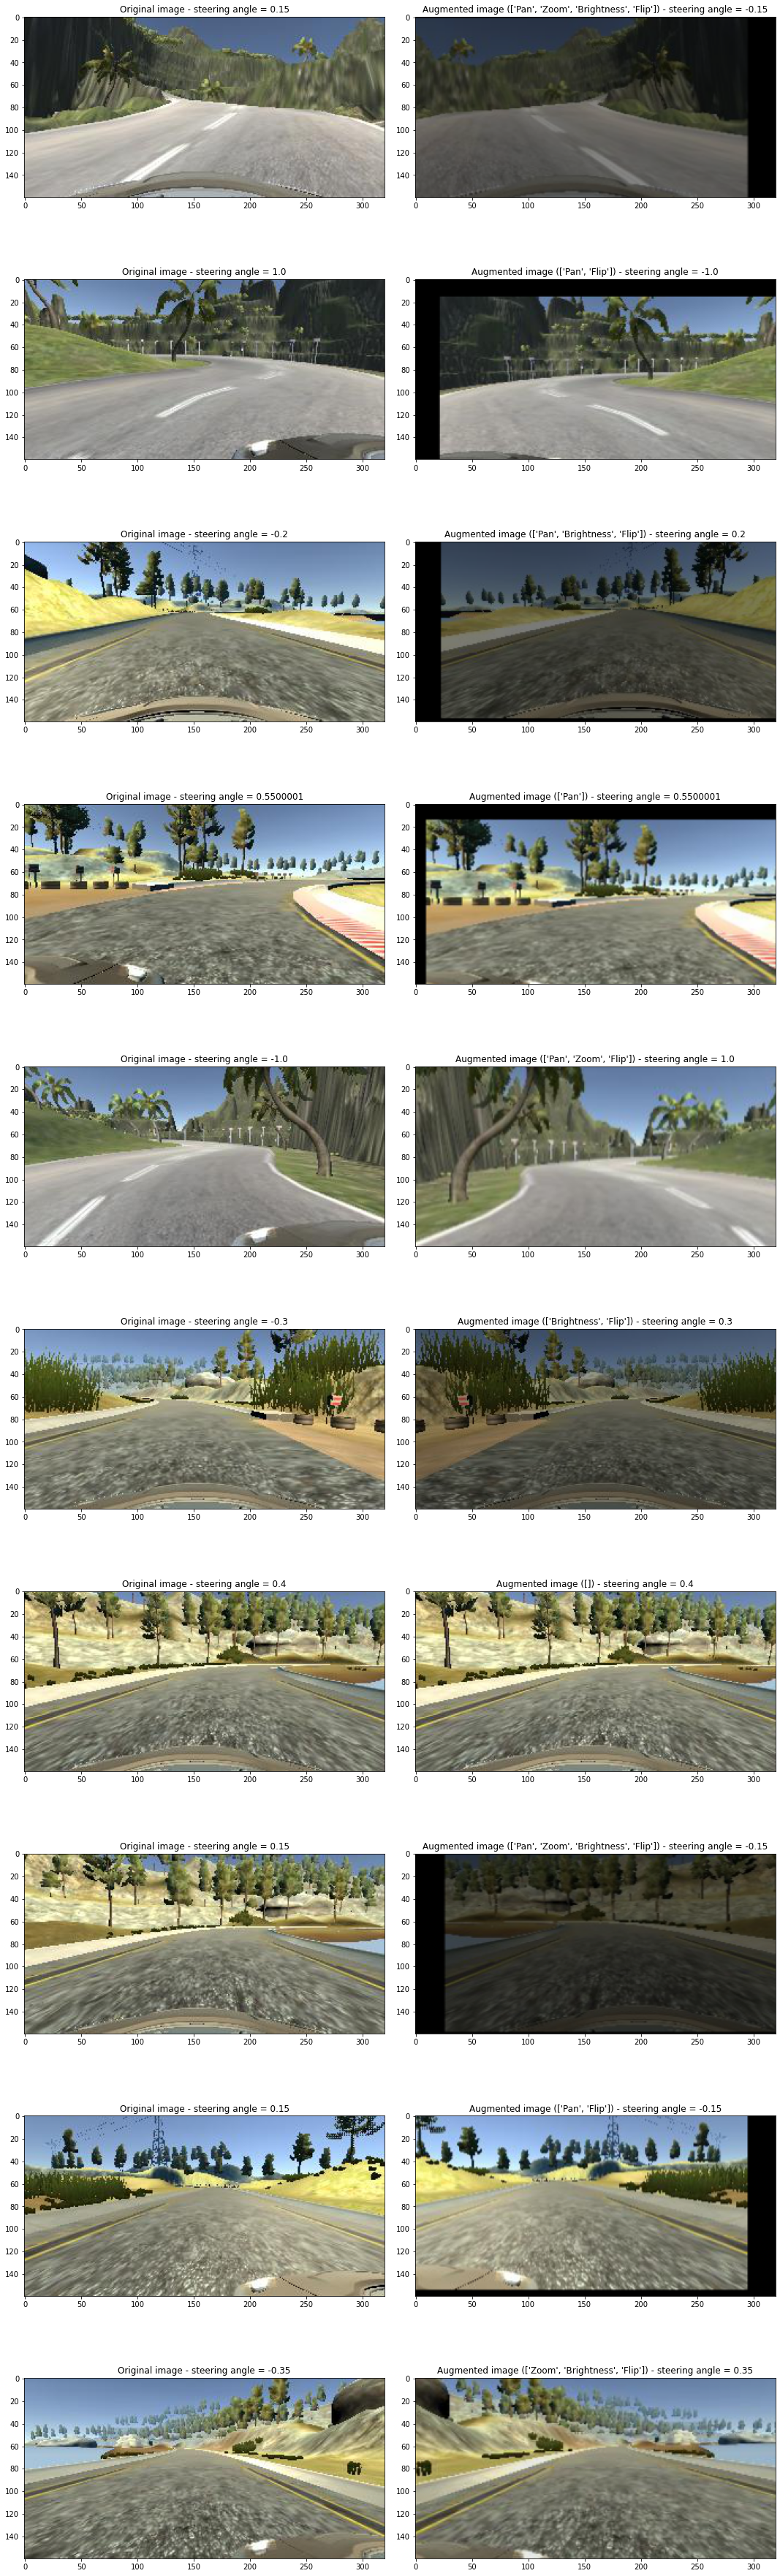

In [71]:
plot_ten_random_augmented_images()

## Preprocessing our data

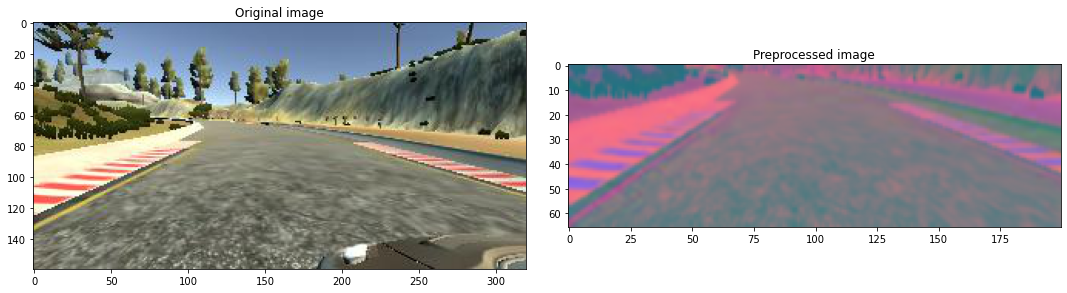

In [72]:
# select a random image to visualize
image = image_paths[100]
original_image = mpimg.imread(image)

preprocessed_image = image_augmentor.image_preprocess(original_image)

plot_two_images(original_image, 
                preprocessed_image, 
                "Original image", 
                "Preprocessed image")

### Batch Image Generator


In [73]:
batch_image_generator = BatchImageGenerator(image_augmentor)

Plot images to verify our generator is working as expected.

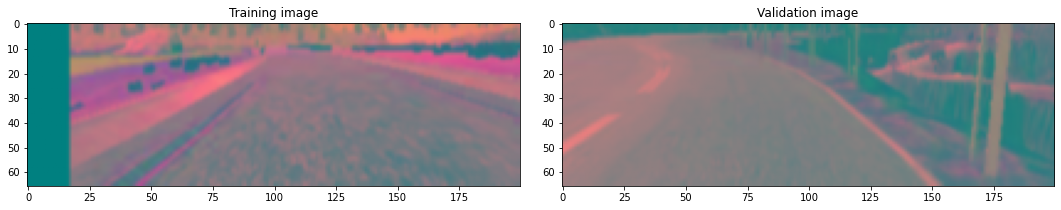

In [74]:
x_train_gen, y_train_gen = next(batch_image_generator.batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_image_generator.batch_generator(X_valid, y_valid, 1, 0))

plot_two_images(x_train_gen[0], 
                x_valid_gen[0], 
                'Training image', 
                'Validation image')

# Defining NVidia Model Architecture for Behavioural Cloning
A popular model used for behavioural cloning is the one proposed by NVidia. It is also implemented in real-life self-driving cars.

We are going to implement this architecture from the paper by [Bojarski, et al. 2016](#References).

![CNN Architecture](./images/CNN_architecture.PNG)


We can see from the diagram that the Nvidia model begins with an Input layer (the Input planes at the bottom of the diagram), and then has a Normalization layer. We are going to skip the Normalization layer in our implementation because we have already normalized the data outside of our model, as part of the image processing. The normalized data is then passed into a convolutional layer.

Note, we can prevent overfitting by using a dropout layer in the model. Note, I experimented with Dropout Layers in different positions in the model at different times, and with varying dropout rates. Eventually, by experimenting with the hyperparameter values during training, I was able to reduce overfitting without the use of dropout layers.
    

In [75]:
model_builder = VehicleControlModelBuilder()
vehicle_control_model = model_builder.nvidia_model()

In [76]:
print(vehicle_control_model.summary())

Model: "Vehicle_Control"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolutional_feature_map_24 (None, 31, 98, 24)        1824      
_________________________________________________________________
Convolutional_feature_map_36 (None, 14, 47, 36)        21636     
_________________________________________________________________
Convolutional_feature_map_48 (None, 5, 22, 48)         43248     
_________________________________________________________________
Convolutional_feature_map_64 (None, 3, 20, 64)         27712     
_________________________________________________________________
Convolutional_feature_map_64 (None, 1, 18, 64)         36928     
_________________________________________________________________
Flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
Fully_connected_100 (Dense)  (None, 100)           

# Training the model


In [77]:
model_trainer = ModelTrainer(vehicle_control_model)

In [78]:
epochs, batch_size, steps_per_epoch, validation_steps = model_trainer.hyperparameters()

print("Model hyperparameters:")
print("Epochs = ", epochs)
print("Batch size =", batch_size)
print("Steps per epoch =", steps_per_epoch)
print("Validation Steps =", validation_steps)

Model hyperparameters:
Epochs =  5
Batch size = 150
Steps per epoch = 300
Validation Steps = 200


In [79]:
RETRAIN_MODEL = True

if RETRAIN_MODEL:
    print("(Re)training model")
    history = model_trainer.train_model(X_train, y_train, X_valid, y_valid)
else:
    print("Using previously-trained model")

(Re)training model
Epoch 1/5
300/300 [==============================] - 181s 605ms/step - loss: 0.1878 - accuracy: 0.0726 - mae: 0.3356 - val_loss: 0.1185 - val_accuracy: 0.0715 - val_mae: 0.2587
Epoch 2/5
300/300 [==============================] - 189s 633ms/step - loss: 0.1436 - accuracy: 0.0756 - mae: 0.2872 - val_loss: 0.1012 - val_accuracy: 0.0739 - val_mae: 0.2431
Epoch 3/5
300/300 [==============================] - 198s 660ms/step - loss: 0.1352 - accuracy: 0.0762 - mae: 0.2756 - val_loss: 0.1009 - val_accuracy: 0.0753 - val_mae: 0.2394
Epoch 4/5
300/300 [==============================] - 178s 596ms/step - loss: 0.1247 - accuracy: 0.0769 - mae: 0.2639 - val_loss: 0.0924 - val_accuracy: 0.0800 - val_mae: 0.2322
Epoch 5/5
300/300 [==============================] - 177s 591ms/step - loss: 0.1188 - accuracy: 0.0760 - mae: 0.2574 - val_loss: 0.0882 - val_accuracy: 0.0753 - val_mae: 0.2230


# Visualize the metrics

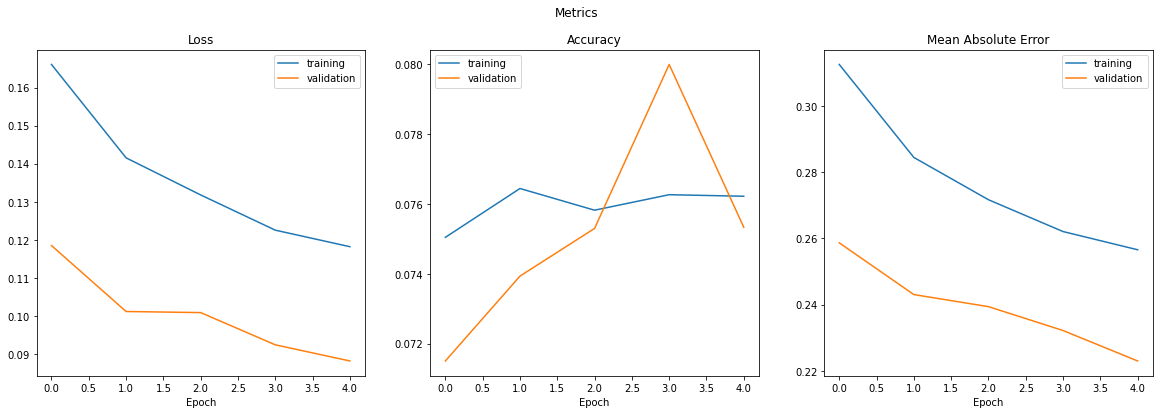

In [80]:
plt.figure(figsize=(20,6))
plt.suptitle("Metrics")


plt.subplot(131)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(132)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(133)
plt.title('Mean Absolute Error')
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')

plt.show()

# Save the trained model

At this point, let's save the model, and verify it is saved to the specified location.

In [81]:
models_dir = 'Models'
model_name = 'model.h5'

vehicle_control_model.save(models_dir + '/' + model_name)

In [82]:
!ls $models_dir

model.h5     model_001.h5


This is the model I will use in the simulated vehicle. The self-driving car will use this model to control the steering.

# Visualizing the CNN model
The `keras_visualizer` outputs a nice visualization of our model. Convert the next cell from markdown back to code if you want to re-run the visualization.

from keras_visualizer import visualizer

visualizer(vehicle_control_model, format='png', view=True)


![](images/model_viz.png)

In [83]:
from tensorflow.keras.utils import plot_model


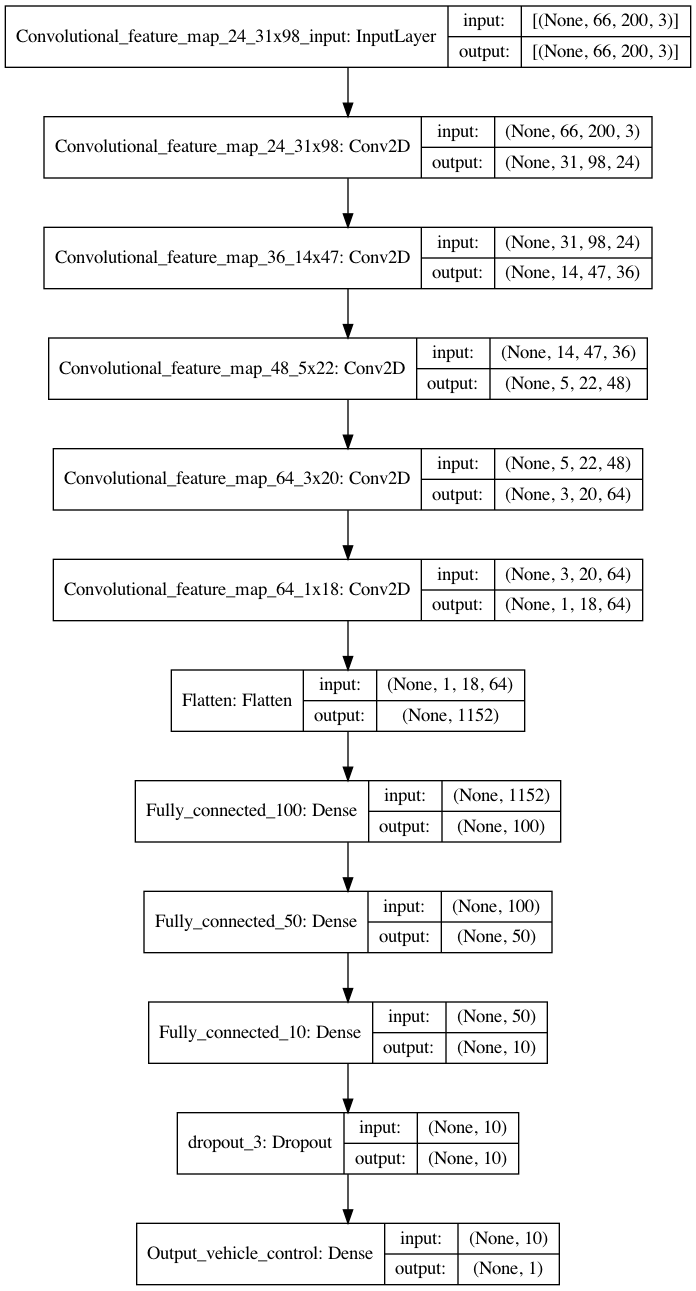

In [84]:
plot_model(vehicle_control_model, to_file="images/model_plot.png", show_shapes=True)

# References
* Bojarski, M., Del Testa, D., Dworakowski, D., Firner, B., Flepp, B., Goyal, P., Jackel, L.D., Monfort, M., Muller, U., Zhang, J. and Zhang, X., 2016. _End to end learning for self-driving cars_. [arXiv preprint arXiv:1604.07316](https://arxiv.org/pdf/1604.07316.pdf).
* Francois Chollet, 2018. Deep Learning with Python, _Chapter 5: Deep Learning for Computer Vision_. Manning Publications Co. 
* Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. _Fast and accurate deep network learning by exponential linear units (elus)_. [arXiv preprint arXiv:1511.07289](https://arxiv.org/pdf/1511.07289.pdf).
* Pedamonti, D., 2018. Comparison of non-linear activation functions for deep neural networks on MNIST classification task. [arXiv preprint arXiv:1804.02763](https://arxiv.org/pdf/1804.02763.pdf).
* Adrian Rosenbrock, 2021. [Visualizing network architectures using Keras and TensorFlow](https://www.pyimagesearch.com/2021/05/22/visualizing-network-architectures-using-keras-and-tensorflow/). pyimagesearch.